# Apriori vs Word2Vec Model Comparison

This notebook compares the performance of Apriori and Word2Vec models for detecting complementary products in market basket analysis. The comparison includes:

- Execution time and memory usage
- Coverage and diversity metrics
- Clustering quality 
- Visualization of key metrics

The `ModelEvaluator` class handles the evaluation process, including model training, metric calculation, and visualization.

## Libraries

In [1]:
import pandas as pd
import numpy as np
import os
import time
import psutil
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from gensim.models import Word2Vec
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

## Configuration and Parameters

In [2]:
# Configuration parameters
# Adjust these parameters as needed

# File path settings
path = r'C:\Users\moham\Apriori_VS_Word2Vec\Dataset'
excel_file = 'df_merged_items_category.xlsx'

# Apriori parameters
apriori_min_support = 0.01
apriori_min_confidence = 0.05
apriori_min_lift = 1.2

# Word2Vec parameters
w2v_vector_size = 100
w2v_window = 5
w2v_min_count = 2
w2v_topn = 10

# Clustering parameters
clustering_n_clusters = 5

## ModelEvaluator Class Definition

In [3]:
class ModelEvaluator:
    """
    Class to evaluate and compare Apriori and Word2Vec models across multiple metrics.
    """
    
    def __init__(self, data_path, excel_file):
        """
        Initialize with dataset path.
        
        Args:
            data_path (str): Path to the data directory
            excel_file (str): Name of the Excel file containing transaction data
        """
        self.data_path = data_path
        self.excel_file = excel_file
        self.file_path = os.path.join(data_path, excel_file)
        self.metrics = {
            'apriori': {},
            'word2vec': {}
        }
        
        # Load dataset
        self.data_excel = pd.read_excel(self.file_path)
        self.data_excel.dropna(subset=['Itemname'], inplace=True)
        
        # Create transaction baskets
        self.basket = self.data_excel.groupby('BillNo')['Itemname'].apply(list)
        self.transactions = self.basket.values.tolist()
        self.unique_products = self.data_excel['Itemname'].unique().tolist()
        
        # Create product to category mapping if category column exists
        self.product_to_category = {}
        if 'category' in self.data_excel.columns:
            # Create a mapping from product name to category
            product_category_mapping = self.data_excel[['Itemname', 'category']].drop_duplicates()
            self.product_to_category = dict(zip(product_category_mapping['Itemname'], product_category_mapping['category']))
        
        # Initialize result dataframes
        self.apriori_rules = None
        self.word2vec_complementary = None
        
        print(f"Dataset loaded with {len(self.basket)} transactions and {len(self.unique_products)} unique products")
        
    def run_apriori(self, min_support=0.01, min_confidence=0.05, min_lift=1.2):
        """
        Run Apriori algorithm and measure performance.
        
        Args:
            min_support (float): Minimum support threshold
            min_confidence (float): Minimum confidence threshold
            min_lift (float): Minimum lift threshold
            
        Returns:
            dict: Performance metrics for Apriori
        """
        print("Running Apriori algorithm...")
        
        # Start the process and memory measurement
        process = psutil.Process(os.getpid())
        start_memory = process.memory_info().rss / 1024 / 1024  # MB
        start_time = time.time()
        
        # Convert transactions to binary format
        te = TransactionEncoder()
        te_ary = te.fit(self.transactions).transform(self.transactions)
        basket_encoded = pd.DataFrame(te_ary, columns=te.columns_)
        
        # Generate frequent itemsets
        frequent_itemsets = apriori(basket_encoded, min_support=min_support, use_colnames=True)
        
        # Generate association rules
        rules = association_rules(frequent_itemsets, metric="lift", min_threshold=min_lift)
        rules = rules[rules['confidence'] >= min_confidence]
        
        # Add antecedent length column
        rules["antecedent_len"] = rules["antecedents"].apply(lambda x: len(x))
        
        # End time and memory measurement
        end_time = time.time()
        end_memory = process.memory_info().rss / 1024 / 1024  # MB
        
        self.apriori_rules = rules
        
        # Convert Apriori rules to product pairs with categories
        self.apriori_product_pairs = self.convert_apriori_rules_to_pairs(rules)
        
        # Store metrics
        self.metrics['apriori'] = {
            'execution_time': end_time - start_time,
            'memory_usage': end_memory - start_memory,
            'num_rules': len(rules),
            'coverage': self.calculate_apriori_coverage(rules),
            'diversity': self.calculate_apriori_diversity(rules),
        }
        
        print(f"Apriori completed with {len(rules)} rules generated")
        return self.metrics['apriori']
    
    def convert_apriori_rules_to_pairs(self, apriori_rules):
        """
        Convert Apriori rules to a consistent product pairs table with category information.
        
        Args:
            apriori_rules (DataFrame): DataFrame containing Apriori rules
            
        Returns:
            DataFrame: Consistent format with one product pair per row and category information
        """
        product_pairs = []
        
        for _, rule in apriori_rules.iterrows():
            # In pandas, frozenset is maintained as is
            antecedents = list(rule['antecedents'])
            consequents = list(rule['consequents'])
            
            # For each combination of antecedent and consequent
            for antecedent in antecedents:
                for consequent in consequents:
                    # Skip if same product
                    if antecedent == consequent:
                        continue
                    
                    # Create a pair
                    pair = {
                        'Original Product': antecedent,
                        'Complementary Product': consequent,
                        'Confidence': rule['confidence'],
                        'Lift': rule['lift'],
                        'Support': rule['support']
                    }
                    
                    # Add category information if available
                    if self.product_to_category:
                        if antecedent in self.product_to_category:
                            pair['Original Product category'] = self.product_to_category[antecedent]
                        else:
                            pair['Original Product category'] = 'Unknown'
                            
                        if consequent in self.product_to_category:
                            pair['Complementary Product category'] = self.product_to_category[consequent]
                        else:
                            pair['Complementary Product category'] = 'Unknown'
                    
                    product_pairs.append(pair)
        
        return pd.DataFrame(product_pairs)
    
    def run_word2vec(self, vector_size=100, window=5, min_count=2, topn=10):
        """
        Run Word2Vec model and measure performance.
        
        Args:
            vector_size (int): Dimensionality of word vectors
            window (int): Context window size
            min_count (int): Minimum word frequency
            topn (int): Number of top complementary products to generate
            
        Returns:
            dict: Performance metrics for Word2Vec
        """
        print("Running Word2Vec model...")
        
        # Start the process and memory measurement
        process = psutil.Process(os.getpid())
        start_memory = process.memory_info().rss / 1024 / 1024  # MB
        start_time = time.time()
        
        # Train Word2Vec model
        model = Word2Vec(
            sentences=self.transactions,
            vector_size=vector_size,
            window=window,
            sg=1,  # Skip-gram model
            negative=5,  # Negative sampling
            min_count=min_count,
            workers=4,
            epochs=10
        )
        
        # Generate complementary products
        comprehensive_results = []
        
        # Dictionary to store model vocabulary for fast lookup
        model_vocab = set(model.wv.index_to_key)
        
        for product in self.unique_products:
            if product in model_vocab:
                try:
                    similar_products = model.wv.most_similar(product, topn=topn)
                    
                    complementary_list = [
                        {
                            'Original Product': product,
                            'Complementary Product': comp_product,
                            'Similarity Score': similarity,
                            'Rank': rank + 1
                        }
                        for rank, (comp_product, similarity) in enumerate(similar_products)
                    ]
                    
                    comprehensive_results.extend(complementary_list)
                except KeyError:
                    pass
            else:
                pass
        
        complementary_products_df = pd.DataFrame(comprehensive_results)
        
        # Add category information to Word2Vec results
        if self.product_to_category and not complementary_products_df.empty:
            # Add category for original product
            complementary_products_df['Original Product category'] = complementary_products_df['Original Product'].apply(
                lambda x: self.product_to_category.get(x, 'Unknown')
            )
            
            # Add category for complementary product
            complementary_products_df['Complementary Product category'] = complementary_products_df['Complementary Product'].apply(
                lambda x: self.product_to_category.get(x, 'Unknown')
            )
        
        # End time and memory measurement
        end_time = time.time()
        end_memory = process.memory_info().rss / 1024 / 1024  # MB
        
        self.word2vec_complementary = complementary_products_df
        self.word2vec_model = model
        
        # Store metrics
        self.metrics['word2vec'] = {
            'execution_time': end_time - start_time,
            'memory_usage': end_memory - start_memory,
            'num_recommendations': len(complementary_products_df),
            'coverage': self.calculate_word2vec_coverage(model, complementary_products_df),
            'diversity': self.calculate_word2vec_diversity(complementary_products_df),
        }
        
        print(f"Word2Vec completed with {len(complementary_products_df)} recommendations generated")
        return self.metrics['word2vec']
    
    def calculate_apriori_coverage(self, rules):
        """
        Calculate coverage for Apriori rules.
        
        Args:
            rules (DataFrame): Association rules
            
        Returns:
            float: Coverage score
        """
        unique_antecedents = set()
        unique_consequents = set()
        
        for _, row in rules.iterrows():
            antecedents = set(row['antecedents'])
            consequents = set(row['consequents'])
            
            unique_antecedents.update(antecedents)
            unique_consequents.update(consequents)
        
        unique_items = unique_antecedents.union(unique_consequents)
        coverage = len(unique_items) / len(self.unique_products)
        
        return coverage
    
    def calculate_word2vec_coverage(self, model, complementary_df):
        """
        Calculate coverage for Word2Vec model.
        
        Args:
            model (Word2Vec): Trained Word2Vec model
            complementary_df (DataFrame): Generated complementary products
            
        Returns:
            float: Coverage score
        """
        products_with_embeddings = complementary_df['Original Product'].nunique()
        coverage = products_with_embeddings / len(self.unique_products)
        
        return coverage
    
    def calculate_apriori_diversity(self, rules):
        """
        Calculate diversity for Apriori rules.
        
        Args:
            rules (DataFrame): Association rules
            
        Returns:
            float: Diversity score
        """
        antecedent_consequents = {}
        
        for _, row in rules.iterrows():
            antecedent = frozenset(row['antecedents'])
            consequent = frozenset(row['consequents'])
            
            if antecedent in antecedent_consequents:
                antecedent_consequents[antecedent].add(consequent)
            else:
                antecedent_consequents[antecedent] = {consequent}
        
        # Calculate average number of unique consequents per antecedent
        if len(antecedent_consequents) > 0:
            diversity = sum(len(consequents) for consequents in antecedent_consequents.values()) / len(antecedent_consequents)
        else:
            diversity = 0
        
        return diversity
    
    def calculate_word2vec_diversity(self, complementary_df):
        """
        Calculate diversity for Word2Vec recommendations.
        
        Args:
            complementary_df (DataFrame): Generated complementary products
            
        Returns:
            float: Diversity score
        """
        total_recommendations = len(complementary_df)
        unique_recommendations = complementary_df['Complementary Product'].nunique()
        
        if total_recommendations > 0:
            diversity = unique_recommendations / total_recommendations
        else:
            diversity = 0
        
        return diversity
    
    def analyze_category_relationships(self):
        """
        Analyze and compare how both methods identify complementary products across categories.
        
        Returns:
            dict: Analysis results for both methods
        """
        results = {'apriori': {}, 'word2vec': {}}
        
        # Only proceed if both methods have been run and category information is available
        if self.product_to_category and self.apriori_product_pairs is not None and self.word2vec_complementary is not None:
            # Analyze Apriori category relationships
            if 'Original Product category' in self.apriori_product_pairs.columns:
                # Count frequency of category combinations
                category_combinations = self.apriori_product_pairs.groupby(
                    ['Original Product category', 'Complementary Product category']
                ).size().reset_index(name='frequency')
                
                # Sort by frequency
                category_combinations = category_combinations.sort_values('frequency', ascending=False)
                
                # Calculate percentage of cross-category vs. same-category recommendations
                same_category = self.apriori_product_pairs[
                    self.apriori_product_pairs['Original Product category'] == 
                    self.apriori_product_pairs['Complementary Product category']
                ]
                same_category_percentage = len(same_category) / len(self.apriori_product_pairs) * 100
                
                results['apriori'] = {
                    'top_category_combinations': category_combinations.head(10),
                    'same_category_percentage': same_category_percentage,
                    'cross_category_percentage': 100 - same_category_percentage
                }
            
            # Analyze Word2Vec category relationships
            if 'Original Product category' in self.word2vec_complementary.columns:
                # Count frequency of category combinations
                category_combinations = self.word2vec_complementary.groupby(
                    ['Original Product category', 'Complementary Product category']
                ).size().reset_index(name='frequency')
                
                # Sort by frequency
                category_combinations = category_combinations.sort_values('frequency', ascending=False)
                
                # Calculate percentage of cross-category vs. same-category recommendations
                same_category = self.word2vec_complementary[
                    self.word2vec_complementary['Original Product category'] == 
                    self.word2vec_complementary['Complementary Product category']
                ]
                same_category_percentage = len(same_category) / len(self.word2vec_complementary) * 100
                
                results['word2vec'] = {
                    'top_category_combinations': category_combinations.head(10),
                    'same_category_percentage': same_category_percentage,
                    'cross_category_percentage': 100 - same_category_percentage
                }
        
        return results
    
    def compare_models(self):
        """
        Compare performance metrics between Apriori and Word2Vec.
        
        Returns:
            DataFrame: Comparison of metrics
        """
        # Ensure both models have been run
        if not self.metrics['apriori'] or not self.metrics['word2vec']:
            print("Both models need to be run before comparison")
            return
        
        # Create comparison DataFrame
        comparison = pd.DataFrame({
            'Metric': [
                'Execution Time (s)',
                'Memory Usage (MB)',
                'Number of Rules/Recommendations',
                'Coverage',
                'Diversity'
            ],
            'Apriori': [
                self.metrics['apriori']['execution_time'],
                self.metrics['apriori']['memory_usage'],
                self.metrics['apriori']['num_rules'],
                self.metrics['apriori']['coverage'],
                self.metrics['apriori']['diversity']
            ],
            'Word2Vec': [
                self.metrics['word2vec']['execution_time'],
                self.metrics['word2vec']['memory_usage'],
                self.metrics['word2vec']['num_recommendations'],
                self.metrics['word2vec']['coverage'],
                self.metrics['word2vec']['diversity']
            ]
        })
        
        return comparison
    
    def visualize_comparison(self, save_path=None):
        """
        Visualize comparison metrics between Apriori and Word2Vec.
        
        Args:
            save_path (str, optional): Path to save the visualization
        """
        comparison = self.compare_models()
        
        # Prepare data for plotting
        metrics_to_plot = ['Execution Time (s)', 'Memory Usage (MB)', 'Coverage', 'Diversity']
        
        # Set up the figure
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        axes = axes.flatten()
        
        for i, metric in enumerate(metrics_to_plot):
            data = comparison[comparison['Metric'] == metric]
            values = data.iloc[0, 1:].astype(float)
            
            # Create bar plot
            ax = axes[i]
            sns.barplot(x=['Apriori', 'Word2Vec'], y=values, ax=ax, palette='viridis')
            ax.set_title(metric, fontsize=14)
            ax.set_ylabel('Value', fontsize=12)
            ax.set_xlabel('')
            
            # Add values on top of bars
            for j, v in enumerate(values):
                ax.text(j, v, f'{v:.4f}', ha='center', va='bottom', fontsize=12)
        
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
        
        plt.show()
    
    def visualize_category_relationships(self, save_path=None):
        """
        Visualize category relationships for both methods.
        
        Args:
            save_path (str, optional): Path to save the visualization
        """
        # Only proceed if category analysis has been performed
        category_analysis = self.analyze_category_relationships()
        
        if not category_analysis['apriori'] or not category_analysis['word2vec']:
            print("Category analysis is not available. Make sure models have been run and category information exists.")
            return
        
        # Set up the figure
        fig, axes = plt.subplots(1, 2, figsize=(18, 8))
        
        # Plot for Apriori
        axes[0].bar(['Same category', 'Cross category'], 
                 [category_analysis['apriori']['same_category_percentage'], 
                  category_analysis['apriori']['cross_category_percentage']])
        axes[0].set_title('Apriori: Category Relationships', fontsize=14)
        axes[0].set_ylabel('Percentage (%)', fontsize=12)
        
        # Add values on top of bars
        for i, v in enumerate([category_analysis['apriori']['same_category_percentage'], 
                               category_analysis['apriori']['cross_category_percentage']]):
            axes[0].text(i, v, f'{v:.1f}%', ha='center', va='bottom', fontsize=12)
        
        # Plot for Word2Vec
        axes[1].bar(['Same category', 'Cross category'], 
                 [category_analysis['word2vec']['same_category_percentage'], 
                  category_analysis['word2vec']['cross_category_percentage']])
        axes[1].set_title('Word2Vec: Category Relationships', fontsize=14)
        axes[1].set_ylabel('Percentage (%)', fontsize=12)
        
        # Add values on top of bars
        for i, v in enumerate([category_analysis['word2vec']['same_category_percentage'], 
                               category_analysis['word2vec']['cross_category_percentage']]):
            axes[1].text(i, v, f'{v:.1f}%', ha='center', va='bottom', fontsize=12)
        
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
        
        plt.show()
    
    def save_results(self, output_dir=None):
        """
        Save evaluation results to files.
        
        Args:
            output_dir (str, optional): Directory to save results
        """
        if output_dir is None:
            output_dir = self.data_path
        
        # Save comparison metrics
        comparison = self.compare_models()
        comparison.to_csv(os.path.join(output_dir, 'model_comparison_metrics.csv'), index=False)
        
        # Save Apriori rules if available
        if self.apriori_rules is not None:
            self.apriori_rules.to_excel(os.path.join(output_dir, 'apriori_rules.xlsx'), index=False)
            
        # Save Apriori product pairs with categories if available
        if hasattr(self, 'apriori_product_pairs') and self.apriori_product_pairs is not None:
            self.apriori_product_pairs.to_excel(os.path.join(output_dir, 'apriori_product_pairs_with_categories.xlsx'), index=False)
        
        # Save Word2Vec recommendations if available
        if self.word2vec_complementary is not None:
            self.word2vec_complementary.to_excel(os.path.join(output_dir, 'word2vec_recommendations.xlsx'), index=False)
        
        # Save visualization
        self.visualize_comparison(save_path=os.path.join(output_dir, 'metric_comparison.png'))
        
        # Save category relationship visualization if applicable
        if hasattr(self, 'product_to_category') and self.product_to_category:
            self.visualize_category_relationships(save_path=os.path.join(output_dir, 'category_relationships.png'))
            
            # Save category analysis results
            category_analysis = self.analyze_category_relationships()
            
            # Save top category combinations for Apriori
            if 'top_category_combinations' in category_analysis['apriori']:
                category_analysis['apriori']['top_category_combinations'].to_excel(
                    os.path.join(output_dir, 'apriori_top_category_combinations.xlsx'), index=False
                )
            
            # Save top category combinations for Word2Vec
            if 'top_category_combinations' in category_analysis['word2vec']:
                category_analysis['word2vec']['top_category_combinations'].to_excel(
                    os.path.join(output_dir, 'word2vec_top_category_combinations.xlsx'), index=False
                )
        
        print(f"Results saved to {output_dir}")

## Initialize the Evaluator

In [4]:
# Initialize evaluator with the configured parameters
evaluator = ModelEvaluator(path, excel_file)

Dataset loaded with 20208 transactions and 4185 unique products


## Run Apriori Algorithm

In [5]:
# Run Apriori algorithm with the configured parameters
apriori_metrics = evaluator.run_apriori(
    min_support=apriori_min_support, 
    min_confidence=apriori_min_confidence, 
    min_lift=apriori_min_lift
)

Running Apriori algorithm...
Apriori completed with 3004 rules generated


## Run Word2Vec Model

In [ ]:
# Run Word2Vec model with the configured parameters
word2vec_metrics = evaluator.run_word2vec(
    vector_size=w2v_vector_size,
    window=w2v_window,
    min_count=w2v_min_count,
    topn=w2v_topn
)

Running Word2Vec model...


## Compare Models

In [ ]:
# Compare models and display the results
comparison = evaluator.compare_models()
print("\nModel Comparison:")
print(comparison)


Model Comparison:
                            Metric      Apriori      Word2Vec
0               Execution Time (s)   188.320375      5.262307
1                Memory Usage (MB)    78.613281      3.574219
2  Number of Rules/Recommendations  3004.000000  38770.000000
3                         Coverage     0.057587      0.926404
4                        Diversity     6.155738      0.096879


## Visualize Comparison

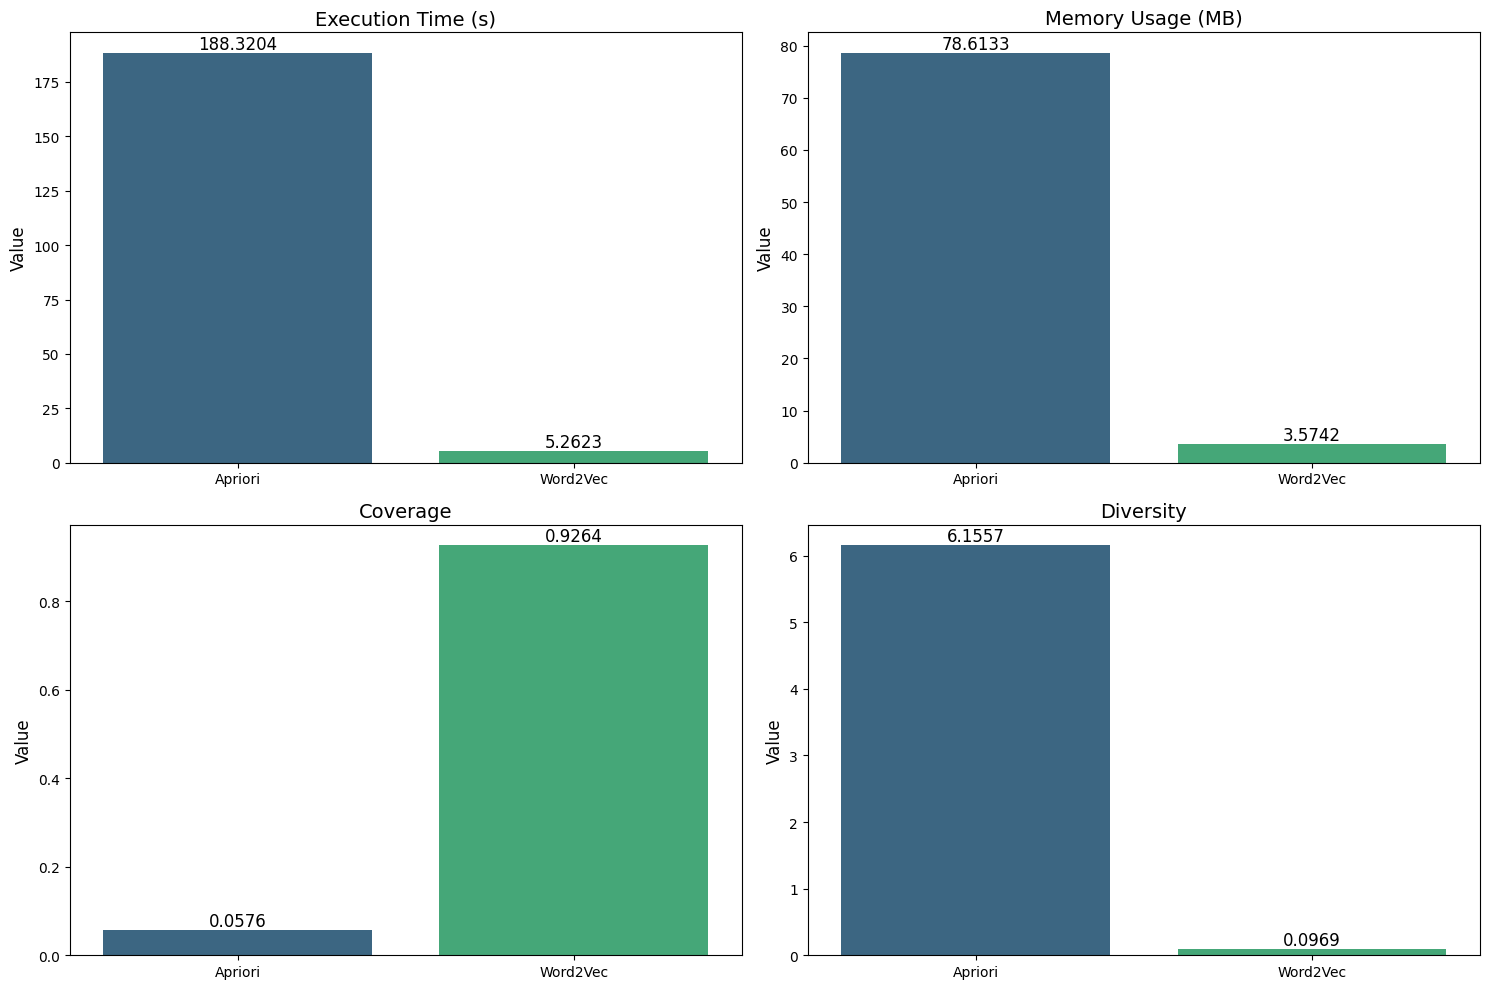

In [ ]:
# Visualize the comparison metrics
evaluator.visualize_comparison()

## Save Results

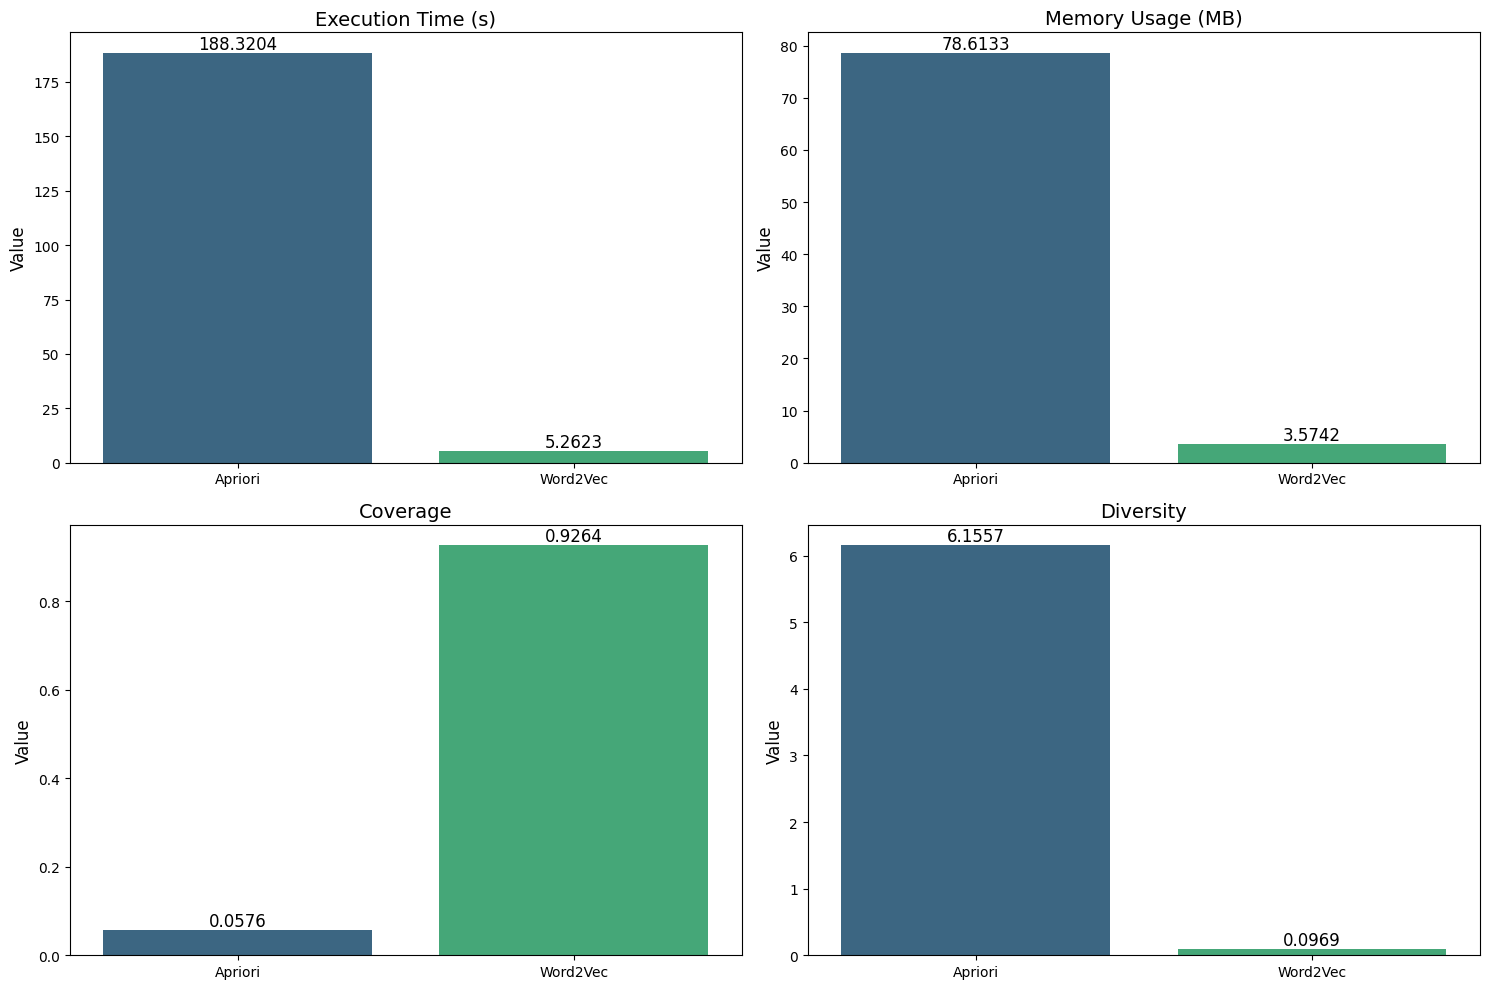

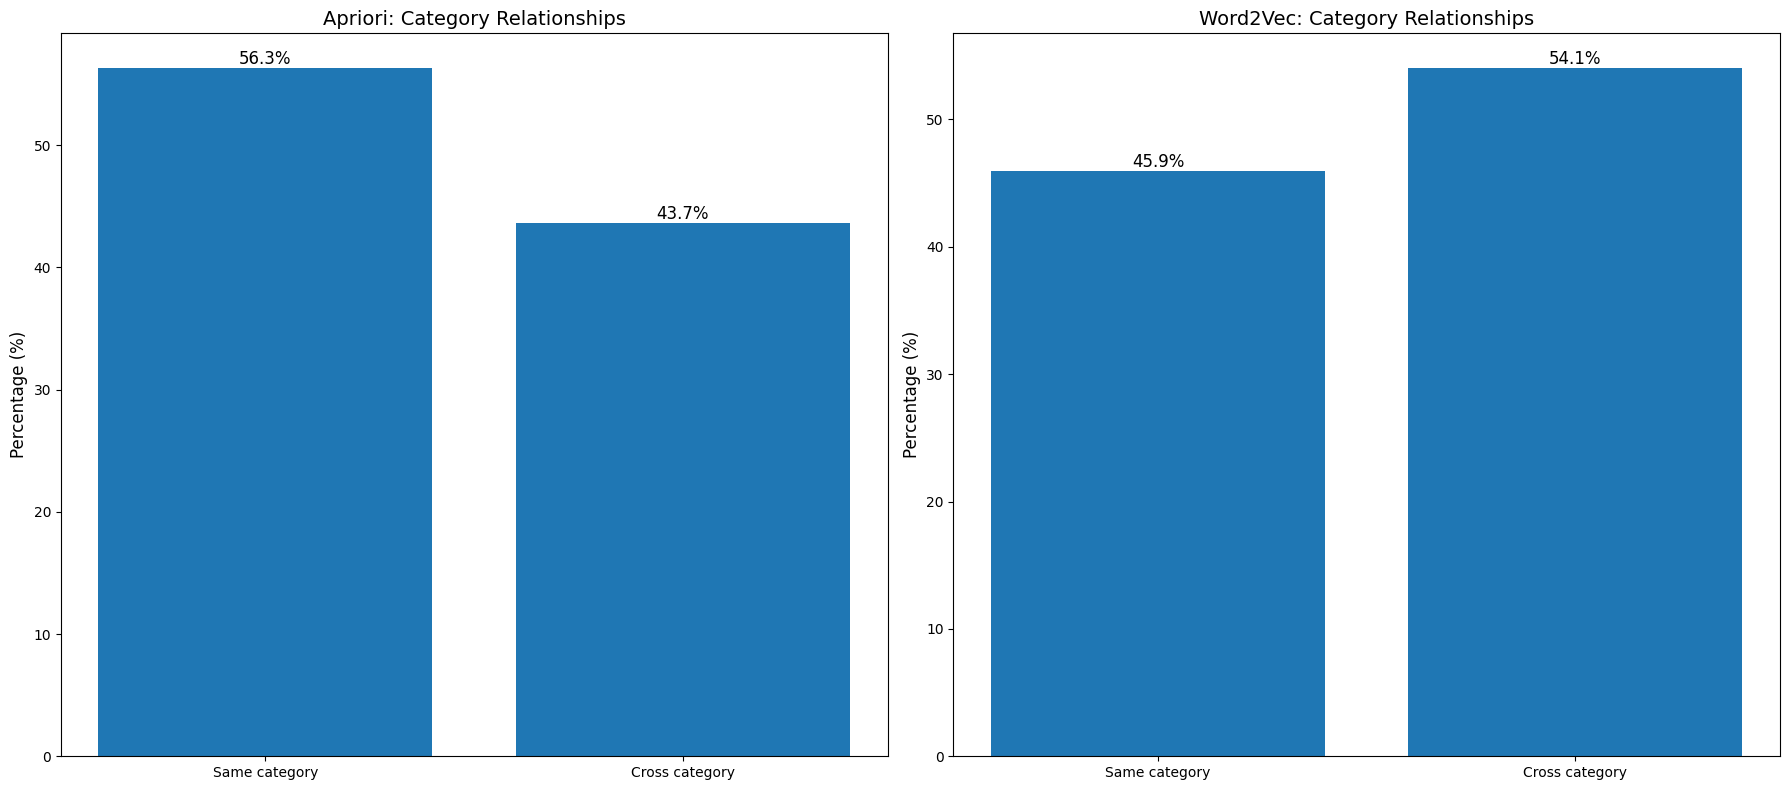

Results saved to C:\Users\moham\Apriori_VS_Word2Vec\Dataset


In [ ]:
# Save the evaluation results
evaluator.save_results()